In [1]:
MODELS = [
    "Classic",
    "Black-Litterman",
    "Black-Litterman 3-Factors",
    "Black-Litterman 5-Factors",
    "Risk Parity",
    "Risk Parity 3-Factors",
    "Hierarchical Risk Parity",
    "Monte Carlo",
]

rm_names = [
    "Standard Deviation",
    "Mean Absolute Deviation",
    "Semi Standard Deviation",
    "First Lower Partial Moment",
    "Second Lower Partial Moment",
    "Entropic Value at Risk",
    "Worst Realization",
    "Range",
    "Max Drawdown",
    "Average Drawdown",
    "Conditional Drawdown at Risk",
    "Entropic Drawdown at Risk",
    "Ulcer Index",
]

## 15 Year Backtest

In [2]:
import quantstats as qs
import vectorbt as vbt
import numpy as np
import pandas as pd

year_data = {}
risk_measures_not_avail = {}

for model in MODELS:
    if model == "Monte Carlo":
        risk_measures = ["Standard Deviation"]
    elif "Risk Parity" in model and "Hierarchical" not in model:
        excluded = ["Worst Realization", "Average Drawdown", "Max Drawdown", "Range"]
        risk_measures = [risk for risk in rm_names if risk not in excluded]
    else:
        risk_measures = rm_names

    for rm in risk_measures:
        try:
            port = vbt.Portfolio.load(
                f"../data/backtest/pickle/{model}_{rm}_B3_Y21.pkl"
            )

            if model == "Risk Parity 3-Factors":
                sharpe = qs.stats.sharpe(port.returns()[:"2024-03-01"]).round(3)
                original_port = vbt.Portfolio.load(
                    f"../data/backtest/pickle/Risk Parity_{rm}_B3_Y21.pkl"
                )
                original_sharpe = qs.stats.sharpe(
                    original_port.returns()[:"2024-03-01"]
                ).round(3)
                print(f"Original Sharpe: {original_sharpe}, New Sharpe: {sharpe}")
                if original_sharpe == sharpe:
                    if not model in risk_measures_not_avail:
                        risk_measures_not_avail[model] = [rm]
                    else:
                        risk_measures_not_avail[model].append(rm)
                    continue

            year_data[f"{model}_{rm}"] = port.value()

        except Exception as e:
            print(f"Model: {model}, Risk Measure: {rm} - {e} not available")
            if not model in risk_measures_not_avail:
                risk_measures_not_avail[model] = [rm]
            else:
                risk_measures_not_avail[model].append(rm)

returns_df = pd.DataFrame.from_dict(year_data, orient="index").T

Original Sharpe: 0.577, New Sharpe: 0.577
Original Sharpe: 0.536, New Sharpe: 0.644
Original Sharpe: 0.7, New Sharpe: 0.62
Original Sharpe: 0.481, New Sharpe: 0.481
Original Sharpe: 0.501, New Sharpe: 0.501
Original Sharpe: 0.516, New Sharpe: 0.516
Original Sharpe: 0.47, New Sharpe: 0.47
Original Sharpe: 0.466, New Sharpe: 0.466
Original Sharpe: 0.492, New Sharpe: 0.492


In [3]:
# Print risk measures not available for each model
rm_to_exclude = set()
for model, risk_measures in risk_measures_not_avail.items():
    print(f"{model}: {risk_measures}")
    rm_to_exclude.update(risk_measures)

# Print the set of risk measures
print(rm_to_exclude)

Risk Parity 3-Factors: ['Standard Deviation', 'First Lower Partial Moment', 'Second Lower Partial Moment', 'Entropic Value at Risk', 'Conditional Drawdown at Risk', 'Entropic Drawdown at Risk', 'Ulcer Index']
{'Entropic Value at Risk', 'Standard Deviation', 'Entropic Drawdown at Risk', 'Second Lower Partial Moment', 'First Lower Partial Moment', 'Conditional Drawdown at Risk', 'Ulcer Index'}


In [4]:
sti_returns = pd.read_parquet("../data/obtain_data/STI.parquet")
# Value of portfolio if 100000 was invested in the beginning of 2009
sti_returns = sti_returns.loc["2009-01-01":]
sti_returns = sti_returns["Close"].pct_change().dropna()
sti_returns = (sti_returns + 1).cumprod() * 100000
print(sti_returns)

Date
2009-01-05    105200.826153
2009-01-06    104588.162880
2009-01-07    102780.221795
2009-01-08     99885.229046
2009-01-09     98705.262478
                  ...      
2024-04-01    176797.960422
2024-04-02    177499.168723
2024-04-03    176129.549541
2024-04-04    176804.525243
2024-04-05    175699.980733
Name: Close, Length: 3810, dtype: float64


In [5]:
values = returns_df
first_diff_index = (values != 100000).idxmax().min()
values = values.loc[first_diff_index:]
values["STI_Standard Deviation"] = sti_returns.copy()

C:\Users\vigne\AppData\Local\Temp\ipykernel_3404\2080495517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values["STI_Standard Deviation"] = sti_returns.copy()


[]


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


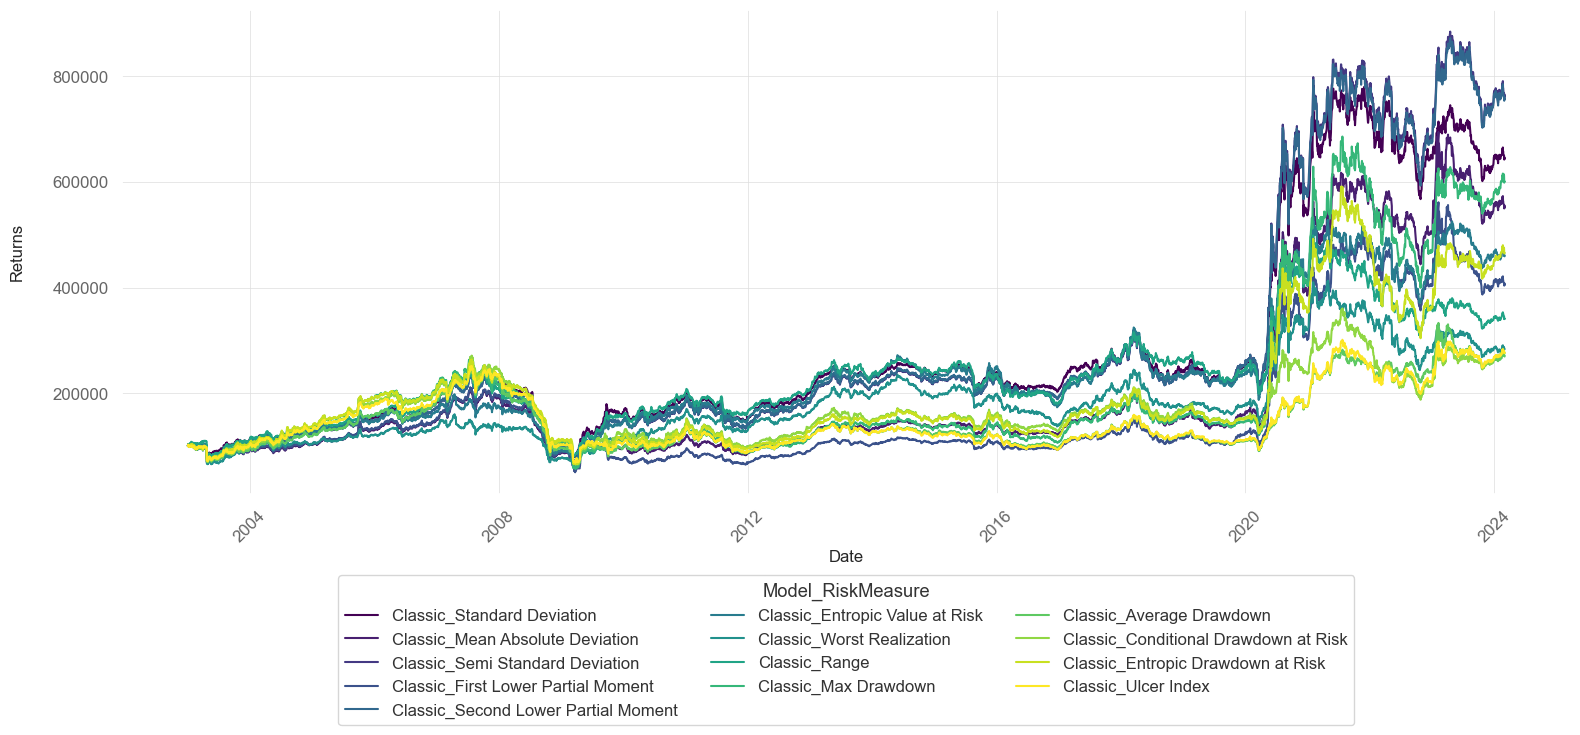

In [6]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quantstats as qs

values = values[:"2024-03-01"]
# values.to_parquet("../data/backtest/validation/all_models_values_Y15.parquet")
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y15.parquet")

# Top 5 sharpes.index model names
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
top_5_models = sharpes.index[:6]
# values = values[top_5_models]
# Values of all classic models
values = values[[model for model in values.columns if "Classic" in model]]
# Print the classic models that did not have a 200K value in 2020
print([model for model in values.columns if values[model].iloc[-1] < 200000])
# Models that have a 200K value in 2020
values = values[[model for model in values.columns if values[model].iloc[-1] > 200000]]


num_colors = len(values.columns)
colors = cm.viridis(np.linspace(0, 1, num_colors))

fig, ax = plt.subplots(figsize=(16, 7))

for i, col in enumerate(values.columns):
    ax.plot(values.index, values[col], color=colors[i], label=col)

ax.set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)

ax.set_ylabel("Returns", fontsize=12, labelpad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=12,
    title="Model_RiskMeasure",
)

plt.show()

In [7]:
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y15.parquet")
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
max_sharpe = sharpes.idxmax()
sharpes = sharpes.round(3)
print(sharpes)
print(f"Max return: {max_sharpe}\n")
print(f"Benchmark Sharpe Ratio {sharpes['STI_Standard Deviation']}")
sharpes = sharpes.to_frame()
sharpes["Model"], sharpes["Risk Measure"] = zip(*sharpes.index.str.split("_"))
sharpes.loc[sharpes["Model"] == "STI", "Risk Measure"] = None
sharpes = sharpes[["Model", "Risk Measure", "Sharpe Ratio"]]
sharpes.reset_index(drop=True, inplace=True)
sharpes.to_csv("../data/backtest/validation/sharpe_ratios_Y15.csv")

Risk Parity_Semi Standard Deviation                    0.749
Risk Parity 3-Factors_Mean Absolute Deviation          0.690
Risk Parity 3-Factors_Semi Standard Deviation          0.663
Black-Litterman 3-Factors_Standard Deviation           0.644
Risk Parity_Standard Deviation                         0.618
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.225
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.224
Black-Litterman_Conditional Drawdown at Risk           0.223
Black-Litterman_Max Drawdown                           0.185
Black-Litterman_Entropic Drawdown at Risk              0.169
Name: Sharpe Ratio, Length: 78, dtype: float64
Max return: Risk Parity_Semi Standard Deviation

Benchmark Sharpe Ratio 0.25


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [8]:
# Calculate Sortino Ratio
sortinos = qs.stats.sortino(values)
sortinos = sortinos.sort_values(ascending=False).rename("Sortino Ratio")
print("\nSortino Ratios (sorted):")
sortinos = sortinos.round(3)
print(sortinos)
max_sortino = sortinos.idxmax()
print(
    f"Max Sortino Ratio: {max_sortino} with a Sortino Ratio of {sortinos.loc[max_sortino]}"
)
print(f"Benchmark Sortino Ratio: {sortinos['STI_Standard Deviation']}")
sortinos = sortinos.to_frame()
sortinos["Model"], sortinos["Risk Measure"] = zip(*sortinos.index.str.split("_"))
sortinos.loc[sortinos["Model"] == "STI", "Risk Measure"] = None
sortinos = sortinos[["Model", "Risk Measure", "Sortino Ratio"]]
sortinos.reset_index(drop=True, inplace=True)
sortinos.to_csv("../data/backtest/validation/sortino_ratios_Y15.csv")

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()



Sortino Ratios (sorted):
Risk Parity_Semi Standard Deviation                    1.064
Risk Parity 3-Factors_Mean Absolute Deviation          0.947
Risk Parity 3-Factors_Semi Standard Deviation          0.924
Black-Litterman 3-Factors_Standard Deviation           0.899
Risk Parity_Standard Deviation                         0.849
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.318
Black-Litterman_Conditional Drawdown at Risk           0.317
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.316
Black-Litterman_Max Drawdown                           0.257
Black-Litterman_Entropic Drawdown at Risk              0.234
Name: Sortino Ratio, Length: 78, dtype: float64
Max Sortino Ratio: Risk Parity_Semi Standard Deviation with a Sortino Ratio of 1.064
Benchmark Sortino Ratio: 0.355


In [9]:
# Calculate Calmar Ratio
calmars = qs.stats.calmar(values)
calmars = calmars.sort_values(ascending=False).rename("Calmar Ratio")
print("Calmar Ratios (sorted):")
calmars = calmars.round(3)
print(calmars)
max_calmar = calmars.idxmax()
print(
    f"Max Calmar Ratio: {max_calmar} with a Calmar Ratio of {calmars.loc[max_calmar]}\n"
)
print(f"Benchmark Calmar Ratio: {calmars['STI_Standard Deviation']}")
calmars = calmars.to_frame()
calmars["Model"], calmars["Risk Measure"] = zip(*calmars.index.str.split("_"))
calmars.loc[calmars["Model"] == "STI", "Risk Measure"] = None
calmars = calmars[["Model", "Risk Measure", "Calmar Ratio"]]
calmars.reset_index(drop=True, inplace=True)
calmars.to_csv("../data/backtest/validation/calmar_ratios_Y15.csv")

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


Calmar Ratios (sorted):
Risk Parity_Semi Standard Deviation                    0.105
Classic_Semi Standard Deviation                        0.098
Classic_Second Lower Partial Moment                    0.097
Black-Litterman 3-Factors_Standard Deviation           0.097
Classic_Standard Deviation                             0.091
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.027
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.026
Black-Litterman_Conditional Drawdown at Risk           0.025
Black-Litterman_Max Drawdown                           0.017
Black-Litterman_Entropic Drawdown at Risk              0.014
Name: Calmar Ratio, Length: 78, dtype: float64
Max Calmar Ratio: Risk Parity_Semi Standard Deviation with a Calmar Ratio of 0.105

Benchmark Calmar Ratio: 0.042


In [10]:
volatilities = qs.stats.volatility(values)
volatilities = volatilities.sort_values(ascending=True).rename("Volatility")
volatilities = volatilities.round(3)
print(volatilities)
min_vol = volatilities.idxmin()
print(f"Min volatility: {min_vol}\n")
print(f"Benchmark Volatility: {volatilities['STI_Standard Deviation']}")
volatilities = volatilities.to_frame()
volatilities["Model"], volatilities["Risk Measure"] = zip(
    *volatilities.index.str.split("_")
)
volatilities.loc[volatilities["Model"] == "STI", "Risk Measure"] = None
volatilities = volatilities[["Model", "Risk Measure", "Volatility"]]
volatilities.reset_index(drop=True, inplace=True)
volatilities.to_csv("../data/backtest/validation/volatility_Y15.csv")

Risk Parity 3-Factors_Mean Absolute Deviation    0.103
Risk Parity_Standard Deviation                   0.104
Risk Parity_Second Lower Partial Moment          0.104
Risk Parity 3-Factors_Semi Standard Deviation    0.105
Risk Parity_Semi Standard Deviation              0.112
                                                 ...  
Classic_Conditional Drawdown at Risk             0.224
Classic_Entropic Drawdown at Risk                0.243
Classic_Max Drawdown                             0.252
Classic_Mean Absolute Deviation                  0.257
Classic_First Lower Partial Moment               0.297
Name: Volatility, Length: 78, dtype: float64
Min volatility: Risk Parity 3-Factors_Mean Absolute Deviation

Benchmark Volatility: 0.122


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [11]:
def calculate_metrics_cumulative(df, frequency):
    cumulative_metrics = pd.DataFrame()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    date_ranges = pd.date_range(df.index.min(), df.index.max(), freq=frequency)
    for idx, end_date in enumerate(date_ranges):
        if end_date > df.index.max():
            break
        # period_data = df.loc[date_ranges[idx-1]:end_date]
        period_data = df.loc[:end_date]
        sharpes = qs.stats.sharpe(period_data).round(3)
        volatilities = qs.stats.volatility(period_data).round(3)
        calmars = qs.stats.calmar(period_data).round(3)
        sortinos = qs.stats.sortino(period_data).round(3)
        metrics = pd.DataFrame(
            {
                "Date": end_date,
                "Model_RiskMeasure": sharpes.index,
                "Sharpe Ratio": sharpes.values,
                "Volatility": volatilities.values,
                "Calmar Ratio": calmars.values,
                "Sortino Ratio": sortinos.values,
            }
        )
        cumulative_metrics = pd.concat([cumulative_metrics, metrics])
    cumulative_metrics[["Model", "RiskMeasure"]] = cumulative_metrics[
        "Model_RiskMeasure"
    ].str.split("_", expand=True)
    return cumulative_metrics.reset_index(drop=True)


monthly_cumulative_metrics = calculate_metrics_cumulative(values, "MS")

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

In [12]:
# monthly_cumulative_metrics.to_parquet(
#     "../data/backtest/validation/monthly_cumulative_metrics_Y15.parquet"
# )

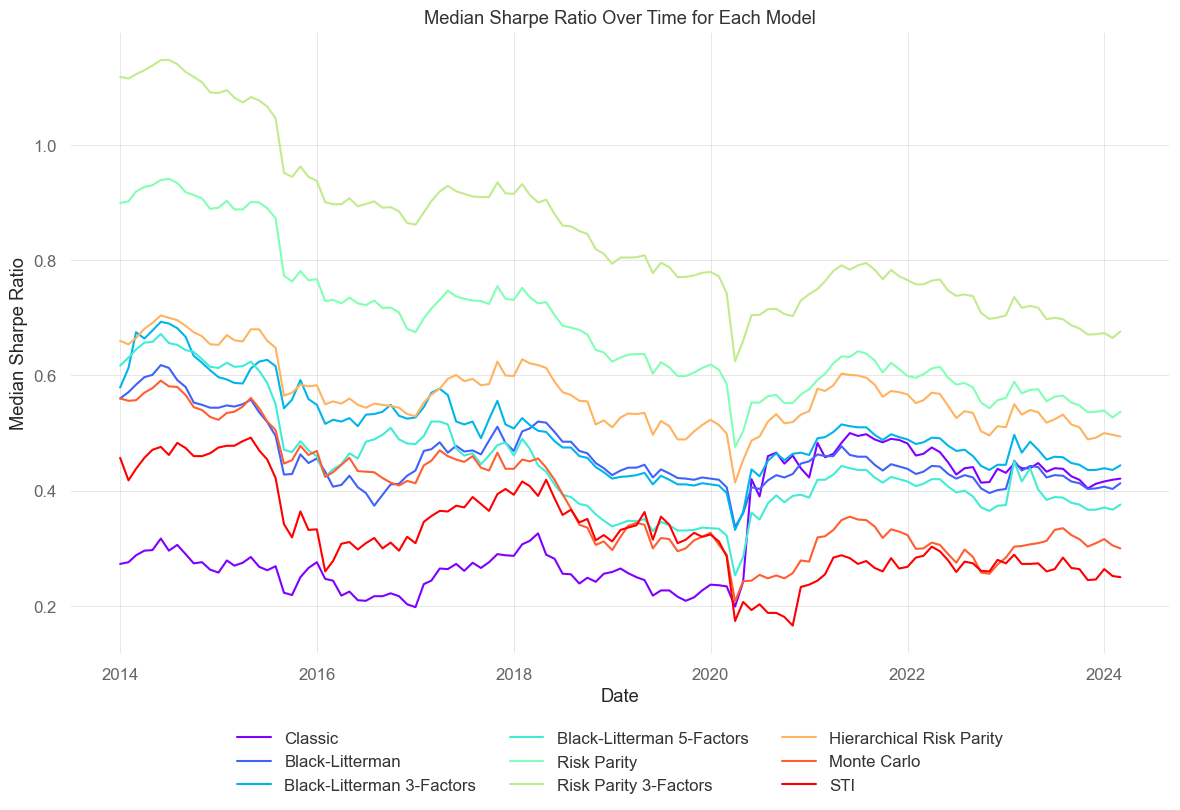

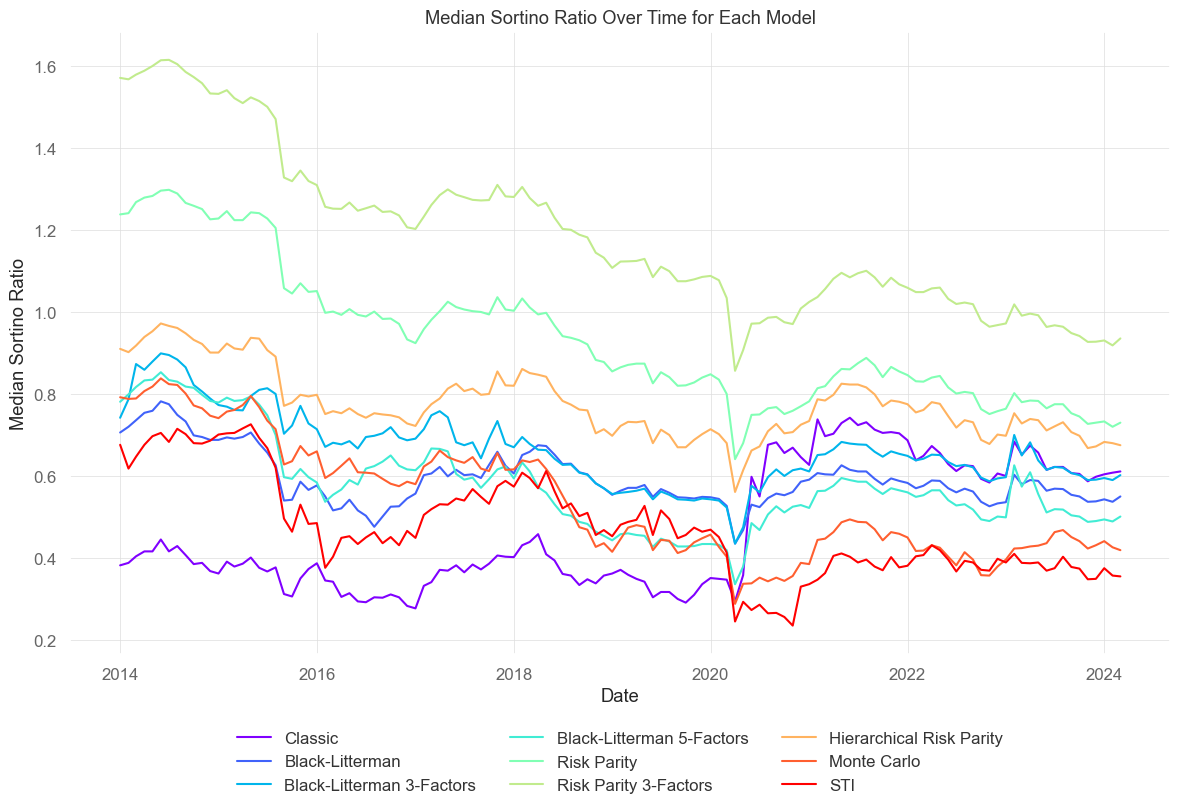

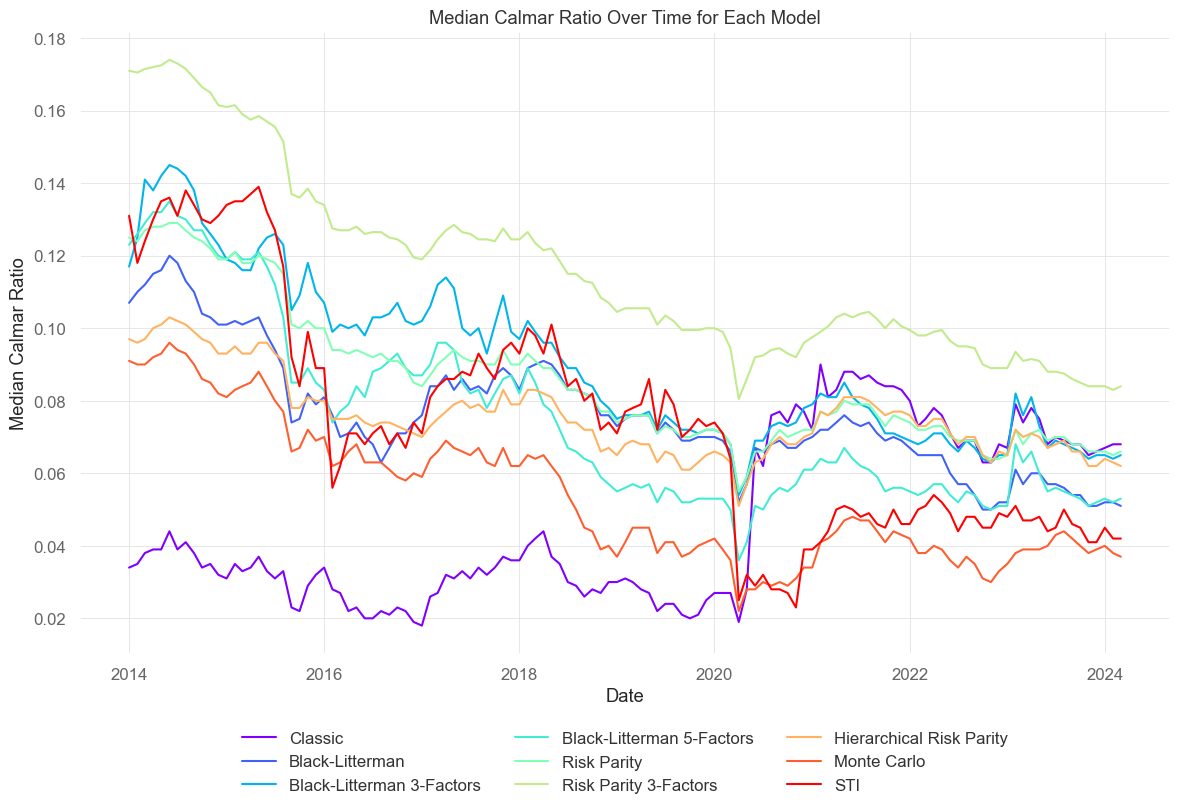

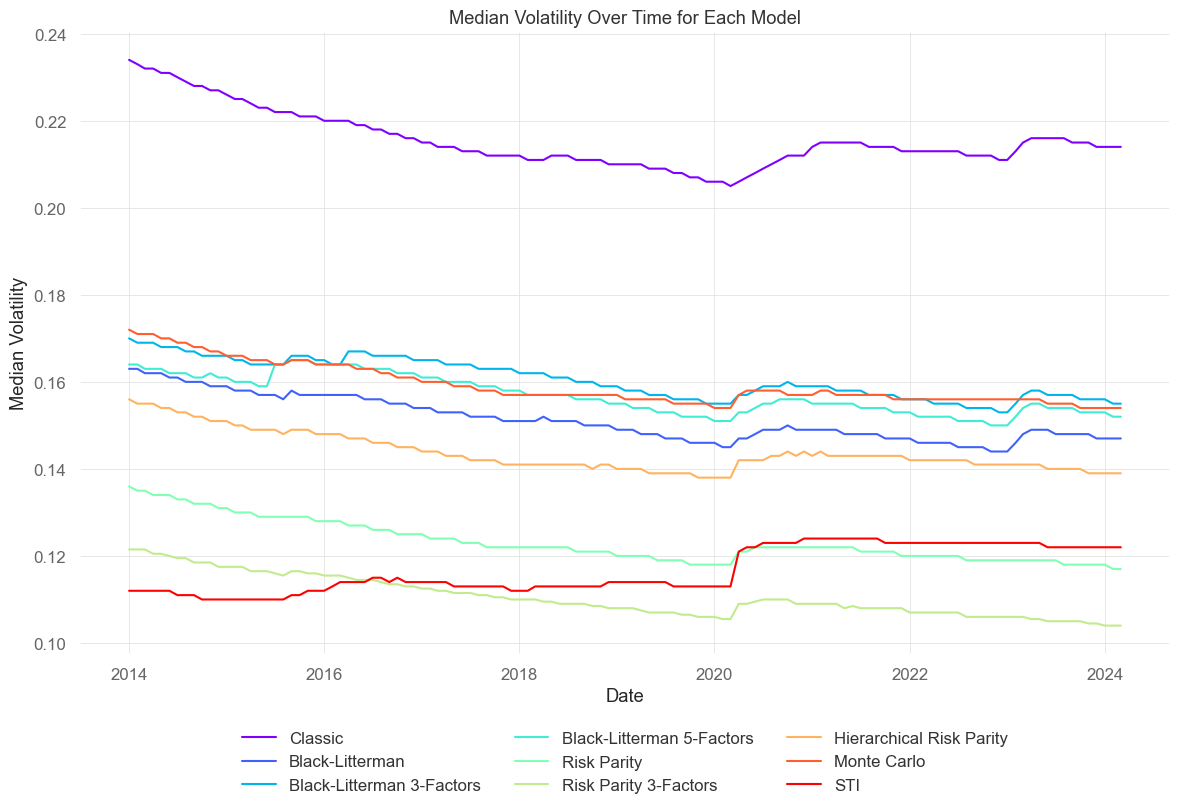

In [13]:
def plot_median_values(metrics_df, group_by_column, measure_types):
    """
    Plots median values for different measure types (models or risk measures)
    across given ratio types.

    :param metrics_df: DataFrame containing the metrics data.
    :param group_by_column: Column name to group by ('Model' or 'RiskMeasure').
    :param measure_types: List of measure types to plot (models or risk measures).
    """
    ratio_types = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
    for ratio in ratio_types:
        plt.figure(figsize=(12, 8))
        colors = cm.rainbow(np.linspace(0, 1, len(measure_types)))
        for measure, color in zip(measure_types, colors):
            if group_by_column == "Model":
                # Filter data for the current model and ratio
                data = metrics_df[metrics_df["Model"] == measure]
            else:
                # Group data by 'RiskMeasure' and 'Date', then unstack
                data = (
                    metrics_df[metrics_df["RiskMeasure"] == measure]
                    .groupby(["Date"])[ratio]
                    .median()
                    .reset_index()
                )

            # Calculate median values
            median_values = data.groupby("Date")[ratio].median()
            median_values = median_values.loc["2014":]  # Adjust as needed

            plt.plot(median_values.index, median_values, label=measure, color=color)

        plt.title(f"Median {ratio} Over Time for Each {group_by_column}")
        plt.xlabel("Date")
        plt.ylabel(f"Median {ratio}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.legend(
            bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3, frameon=False
        )
        plt.show()


# Example usage for models
plot_median_values(
    monthly_cumulative_metrics, "Model", monthly_cumulative_metrics["Model"].unique()
)

In [14]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

model_medians_end = (
    monthly_cumulative_metrics.groupby("Model")[metrics].median().round(3)
)

for metric in metrics:
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    ).to_csv(f"../data/backtest/validation/model_{metric}_rankings_Y15.csv")

Rankings and Median Values for Sharpe Ratio:
                           Sharpe Ratio  Sharpe Ratio_Ranking
Model                                                        
Risk Parity 3-Factors             1.006                   1.0
Risk Parity                       0.754                   2.0
Hierarchical Risk Parity          0.603                   3.0
Black-Litterman 3-Factors         0.562                   4.0
Black-Litterman                   0.536                   5.0
Black-Litterman 5-Factors         0.521                   6.0
Monte Carlo                       0.506                   7.0
Classic                           0.373                   8.0
STI                               0.364                   9.0 

Rankings and Median Values for Sortino Ratio:
                           Sortino Ratio  Sortino Ratio_Ranking
Model                                                          
Risk Parity 3-Factors              1.408                    1.0
Risk Parity                      

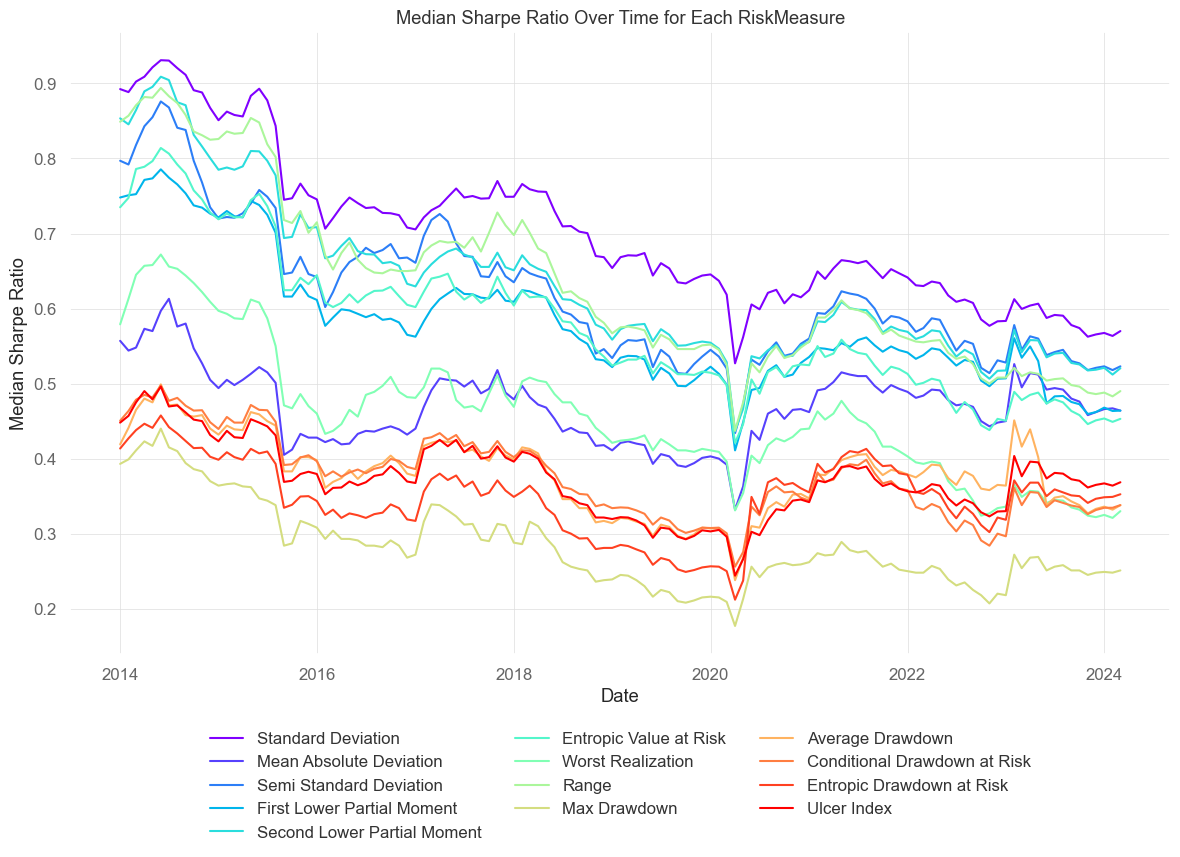

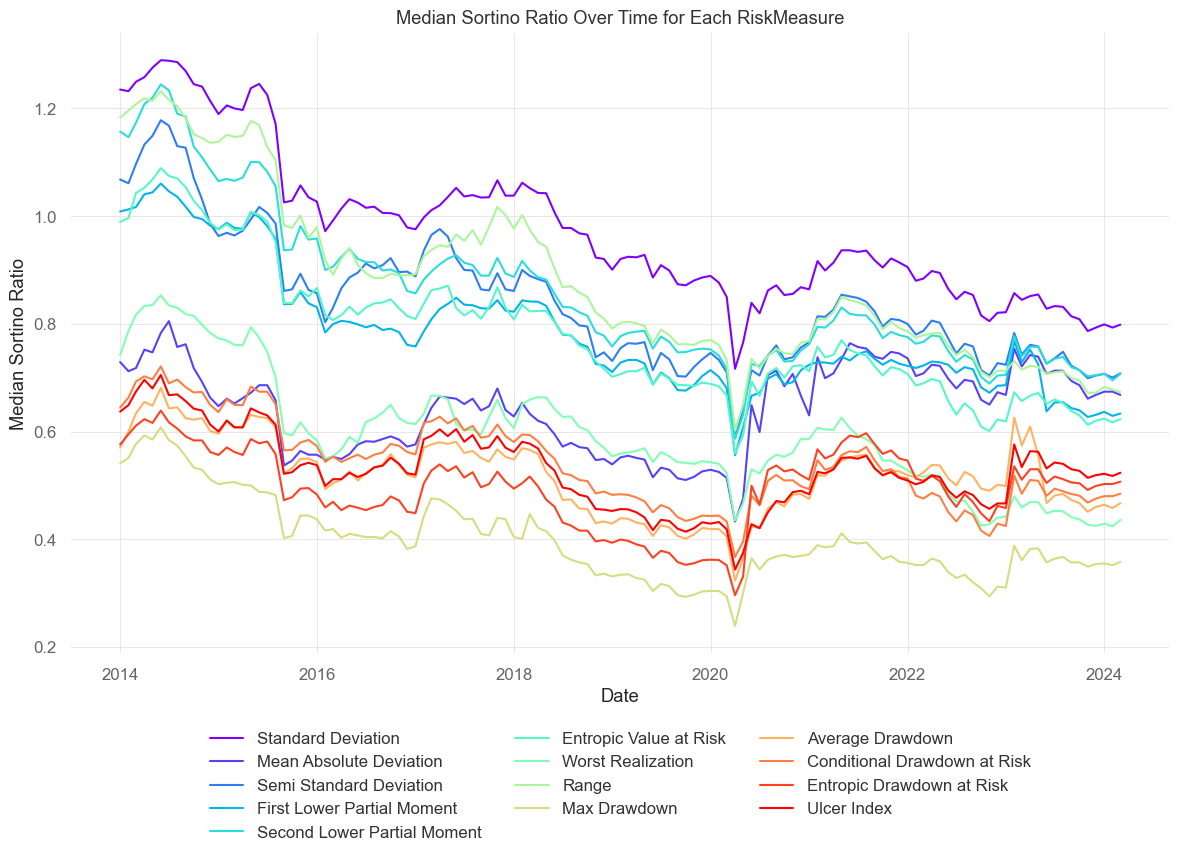

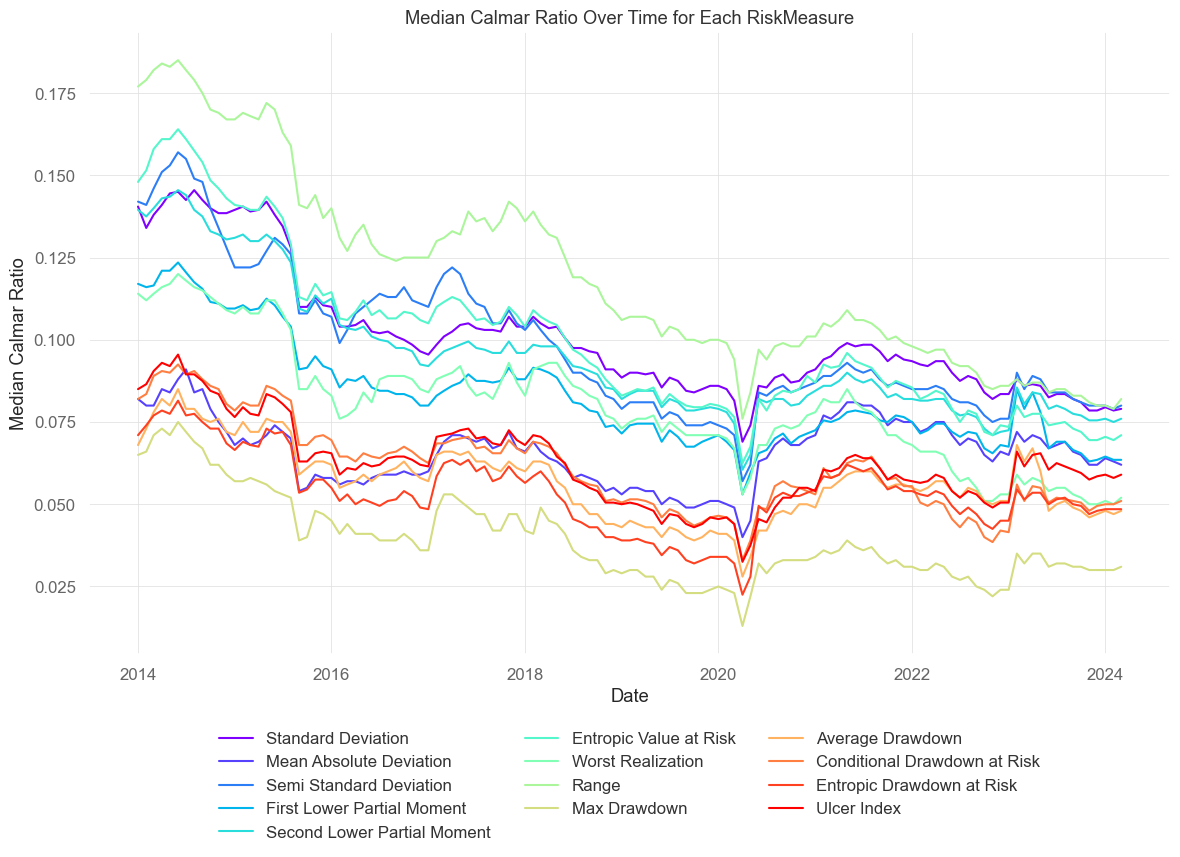

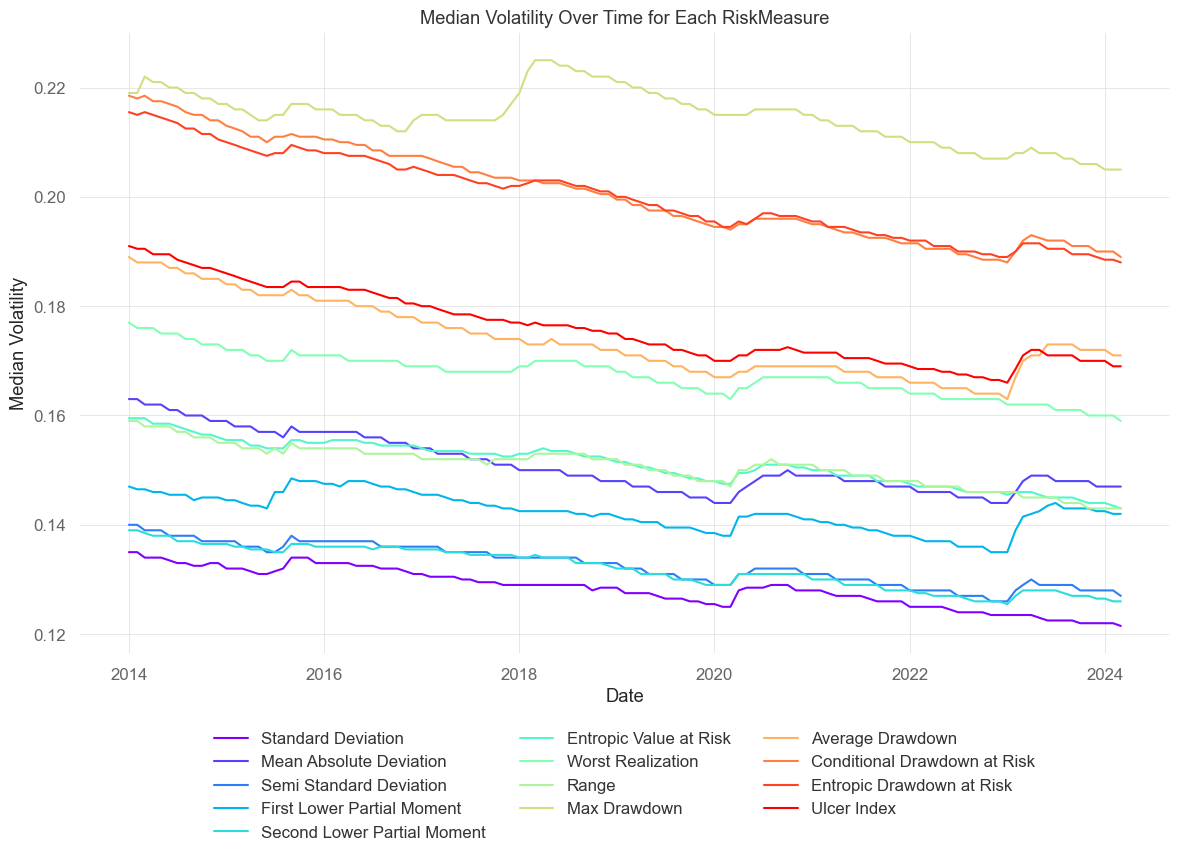

In [15]:
plot_median_values(
    monthly_cumulative_metrics,
    "RiskMeasure",
    monthly_cumulative_metrics["RiskMeasure"].unique(),
)

In [16]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

# Exclude the STI model
monthly_cumulative_metrics_temp = monthly_cumulative_metrics[
    monthly_cumulative_metrics["Model"] != "STI"
]
# Calculate the median values for each model at the end of the period
model_medians_end = (
    monthly_cumulative_metrics_temp.groupby("RiskMeasure")[metrics].median().round(3)
)

# Adjust rankings for each metric and print them separately
for metric in metrics:
    # Rank models based on the current metric, considering the appropriate ascending flag
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    # Print the median values and rankings for the current metric
    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    ).to_csv(f"../data/backtest/validation/rm_{metric}_rankings_Y15.csv")

Rankings and Median Values for Sharpe Ratio:
                              Sharpe Ratio  Sharpe Ratio_Ranking
RiskMeasure                                                     
Standard Deviation                   0.772                   1.0
Semi Standard Deviation              0.734                   2.0
Range                                0.696                   3.0
Second Lower Partial Moment          0.686                   4.0
Entropic Value at Risk               0.631                   5.0
First Lower Partial Moment           0.600                   6.0
Mean Absolute Deviation              0.550                   7.0
Worst Realization                    0.468                   8.0
Conditional Drawdown at Risk         0.453                   9.0
Ulcer Index                          0.443                  10.0
Entropic Drawdown at Risk            0.431                  11.0
Average Drawdown                     0.390                  12.0
Max Drawdown                         0.352   

## 10 Year Backtest

In [17]:
import quantstats as qs
import vectorbt as vbt
import numpy as np
import pandas as pd

year_data = {}
risk_measures_not_avail = {}

for model in MODELS:
    if model == "Monte Carlo":
        risk_measures = ["Standard Deviation"]
    elif "Risk Parity" in model and "Hierarchical" not in model:
        excluded = ["Worst Realization", "Average Drawdown", "Max Drawdown", "Range"]
        risk_measures = [risk for risk in rm_names if risk not in excluded]
    else:
        risk_measures = rm_names

    for rm in risk_measures:
        try:
            port = vbt.Portfolio.load(
                f"../data/backtest/pickle/{model}_{rm}_B3_Y21.pkl"
            )

            if model == "Risk Parity 3-Factors":
                sharpe = qs.stats.sharpe(port.returns()[:"2024-03-01"]).round(3)
                original_port = vbt.Portfolio.load(
                    f"../data/backtest/pickle/Risk Parity_{rm}_B3_Y21.pkl"
                )
                original_sharpe = qs.stats.sharpe(
                    original_port.returns()[:"2024-03-01"]
                ).round(3)
                print(f"Original Sharpe: {original_sharpe}, New Sharpe: {sharpe}")
                if original_sharpe == sharpe:
                    if not model in risk_measures_not_avail:
                        risk_measures_not_avail[model] = [rm]
                    else:
                        risk_measures_not_avail[model].append(rm)
                    continue

            year_data[f"{model}_{rm}"] = port.value()

        except Exception as e:
            print(f"Model: {model}, Risk Measure: {rm} - {e} not available")
            if not model in risk_measures_not_avail:
                risk_measures_not_avail[model] = [rm]
            else:
                risk_measures_not_avail[model].append(rm)

returns_df = pd.DataFrame.from_dict(year_data, orient="index").T

Original Sharpe: 0.577, New Sharpe: 0.577
Original Sharpe: 0.536, New Sharpe: 0.644
Original Sharpe: 0.7, New Sharpe: 0.62
Original Sharpe: 0.481, New Sharpe: 0.481
Original Sharpe: 0.501, New Sharpe: 0.501
Original Sharpe: 0.516, New Sharpe: 0.516
Original Sharpe: 0.47, New Sharpe: 0.47
Original Sharpe: 0.466, New Sharpe: 0.466
Original Sharpe: 0.492, New Sharpe: 0.492


In [18]:
# Print risk measures not available for each model
rm_to_exclude = set()
for model, risk_measures in risk_measures_not_avail.items():
    print(f"{model}: {risk_measures}")
    rm_to_exclude.update(risk_measures)

# Print the set of risk measures
print(rm_to_exclude)

Risk Parity 3-Factors: ['Standard Deviation', 'First Lower Partial Moment', 'Second Lower Partial Moment', 'Entropic Value at Risk', 'Conditional Drawdown at Risk', 'Entropic Drawdown at Risk', 'Ulcer Index']
{'Entropic Value at Risk', 'Standard Deviation', 'Entropic Drawdown at Risk', 'Second Lower Partial Moment', 'First Lower Partial Moment', 'Conditional Drawdown at Risk', 'Ulcer Index'}


In [19]:
sti_returns = pd.read_parquet("../data/obtain_data/STI.parquet")
# Value of portfolio if 100000 was invested in the beginning of 2009
sti_returns = sti_returns.loc["2014-01-01":]
sti_returns = sti_returns["Close"].pct_change().dropna()
sti_returns = (sti_returns + 1).cumprod() * 100000
print(sti_returns)

Date
2014-01-03     98639.852174
2014-01-06     98398.883797
2014-01-07     98306.269315
2014-01-08     99244.011128
2014-01-09     99078.953865
                  ...      
2024-04-01    101897.531762
2024-04-02    102301.673274
2024-04-03    101512.293048
2024-04-04    101901.315398
2024-04-05    101264.710999
Name: Close, Length: 2568, dtype: float64


In [20]:
values = returns_df
first_diff_index = (values != 100000).idxmax().min()
values = values.loc[first_diff_index:]
values["STI_Standard Deviation"] = sti_returns.copy()

C:\Users\vigne\AppData\Local\Temp\ipykernel_3404\2080495517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values["STI_Standard Deviation"] = sti_returns.copy()


[]


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


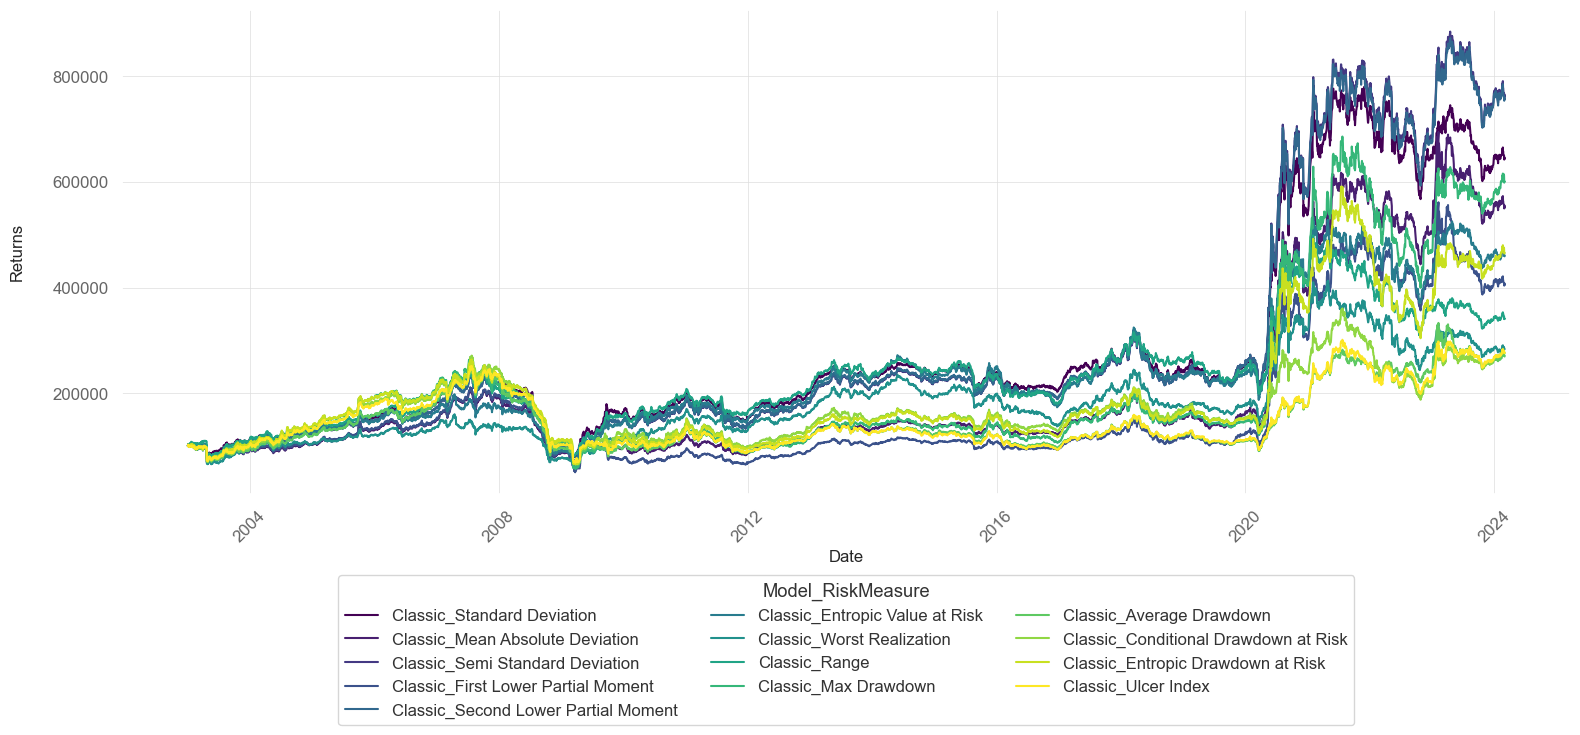

In [21]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quantstats as qs

values = values[:"2024-03-01"]
# values.to_parquet("../data/backtest/validation/all_models_values_Y10.parquet")
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y10.parquet")

# Top 5 sharpes.index model names
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
top_5_models = sharpes.index[:6]
# values = values[top_5_models]
# Values of all classic models
values = values[[model for model in values.columns if "Classic" in model]]
# Print the classic models that did not have a 200K value in 2020
print([model for model in values.columns if values[model].iloc[-1] < 200000])
# Models that have a 200K value in 2020
values = values[[model for model in values.columns if values[model].iloc[-1] > 200000]]


num_colors = len(values.columns)
colors = cm.viridis(np.linspace(0, 1, num_colors))

fig, ax = plt.subplots(figsize=(16, 7))

for i, col in enumerate(values.columns):
    ax.plot(values.index, values[col], color=colors[i], label=col)

ax.set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)

ax.set_ylabel("Returns", fontsize=12, labelpad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=12,
    title="Model_RiskMeasure",
)

plt.show()

In [22]:
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y10.parquet")
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
max_sharpe = sharpes.idxmax()
sharpes = sharpes.round(3)
print(sharpes)
print(f"Max return: {max_sharpe}\n")
print(f"Benchmark Sharpe Ratio {sharpes['STI_Standard Deviation']}")
sharpes = sharpes.to_frame()
sharpes["Model"], sharpes["Risk Measure"] = zip(*sharpes.index.str.split("_"))
sharpes.loc[sharpes["Model"] == "STI", "Risk Measure"] = None
sharpes = sharpes[["Model", "Risk Measure", "Sharpe Ratio"]]
sharpes.reset_index(drop=True, inplace=True)
sharpes.to_csv("../data/backtest/validation/sharpe_ratios_Y10.csv")

Risk Parity_Semi Standard Deviation                    0.749
Risk Parity 3-Factors_Mean Absolute Deviation          0.690
Risk Parity 3-Factors_Semi Standard Deviation          0.663
Black-Litterman 3-Factors_Standard Deviation           0.644
Risk Parity_Standard Deviation                         0.618
                                                       ...  
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.224
Black-Litterman_Conditional Drawdown at Risk           0.223
Black-Litterman_Max Drawdown                           0.185
Black-Litterman_Entropic Drawdown at Risk              0.169
STI_Standard Deviation                                 0.046
Name: Sharpe Ratio, Length: 78, dtype: float64
Max return: Risk Parity_Semi Standard Deviation

Benchmark Sharpe Ratio 0.046


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [23]:
# Calculate Sortino Ratio
sortinos = qs.stats.sortino(values)
sortinos = sortinos.sort_values(ascending=False).rename("Sortino Ratio")
print("\nSortino Ratios (sorted):")
sortinos = sortinos.round(3)
print(sortinos)
max_sortino = sortinos.idxmax()
print(
    f"Max Sortino Ratio: {max_sortino} with a Sortino Ratio of {sortinos.loc[max_sortino]}"
)
print(f"Benchmark Sortino Ratio: {sortinos['STI_Standard Deviation']}")
sortinos = sortinos.to_frame()
sortinos["Model"], sortinos["Risk Measure"] = zip(*sortinos.index.str.split("_"))
sortinos.loc[sortinos["Model"] == "STI", "Risk Measure"] = None
sortinos = sortinos[["Model", "Risk Measure", "Sortino Ratio"]]
sortinos.reset_index(drop=True, inplace=True)
sortinos.to_csv("../data/backtest/validation/sortino_ratios_Y10.csv")

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()



Sortino Ratios (sorted):
Risk Parity_Semi Standard Deviation                    1.064
Risk Parity 3-Factors_Mean Absolute Deviation          0.947
Risk Parity 3-Factors_Semi Standard Deviation          0.924
Black-Litterman 3-Factors_Standard Deviation           0.899
Risk Parity_Standard Deviation                         0.849
                                                       ...  
Black-Litterman_Conditional Drawdown at Risk           0.317
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.316
Black-Litterman_Max Drawdown                           0.257
Black-Litterman_Entropic Drawdown at Risk              0.234
STI_Standard Deviation                                 0.064
Name: Sortino Ratio, Length: 78, dtype: float64
Max Sortino Ratio: Risk Parity_Semi Standard Deviation with a Sortino Ratio of 1.064
Benchmark Sortino Ratio: 0.064


In [24]:
# Calculate Calmar Ratio
calmars = qs.stats.calmar(values)
calmars = calmars.sort_values(ascending=False).rename("Calmar Ratio")
print("Calmar Ratios (sorted):")
calmars = calmars.round(3)
print(calmars)
max_calmar = calmars.idxmax()
print(
    f"Max Calmar Ratio: {max_calmar} with a Calmar Ratio of {calmars.loc[max_calmar]}\n"
)
print(f"Benchmark Calmar Ratio: {calmars['STI_Standard Deviation']}")
calmars = calmars.to_frame()
calmars["Model"], calmars["Risk Measure"] = zip(*calmars.index.str.split("_"))
calmars.loc[calmars["Model"] == "STI", "Risk Measure"] = None
calmars = calmars[["Model", "Risk Measure", "Calmar Ratio"]]
calmars.reset_index(drop=True, inplace=True)
calmars.to_csv("../data/backtest/validation/calmar_ratios_Y10.csv")

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


Calmar Ratios (sorted):
Risk Parity_Semi Standard Deviation                    0.105
Classic_Semi Standard Deviation                        0.098
Classic_Second Lower Partial Moment                    0.097
Black-Litterman 3-Factors_Standard Deviation           0.097
Classic_Standard Deviation                             0.091
                                                       ...  
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.026
Black-Litterman_Conditional Drawdown at Risk           0.025
Black-Litterman_Max Drawdown                           0.017
Black-Litterman_Entropic Drawdown at Risk              0.014
STI_Standard Deviation                                 0.000
Name: Calmar Ratio, Length: 78, dtype: float64
Max Calmar Ratio: Risk Parity_Semi Standard Deviation with a Calmar Ratio of 0.105

Benchmark Calmar Ratio: 0.0


In [25]:
volatilities = qs.stats.volatility(values)
volatilities = volatilities.sort_values(ascending=True).rename("Volatility")
volatilities = volatilities.round(3)
print(volatilities)
min_vol = volatilities.idxmin()
print(f"Min volatility: {min_vol}\n")
print(f"Benchmark Volatility: {volatilities['STI_Standard Deviation']}")
volatilities = volatilities.to_frame()
volatilities["Model"], volatilities["Risk Measure"] = zip(
    *volatilities.index.str.split("_")
)
volatilities.loc[volatilities["Model"] == "STI", "Risk Measure"] = None
volatilities = volatilities[["Model", "Risk Measure", "Volatility"]]
volatilities.reset_index(drop=True, inplace=True)
volatilities.to_csv("../data/backtest/validation/volatility_Y10.csv")

STI_Standard Deviation                           0.091
Risk Parity 3-Factors_Mean Absolute Deviation    0.103
Risk Parity_Standard Deviation                   0.104
Risk Parity_Second Lower Partial Moment          0.104
Risk Parity 3-Factors_Semi Standard Deviation    0.105
                                                 ...  
Classic_Conditional Drawdown at Risk             0.224
Classic_Entropic Drawdown at Risk                0.243
Classic_Max Drawdown                             0.252
Classic_Mean Absolute Deviation                  0.257
Classic_First Lower Partial Moment               0.297
Name: Volatility, Length: 78, dtype: float64
Min volatility: STI_Standard Deviation

Benchmark Volatility: 0.091


c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [26]:
monthly_cumulative_metrics = calculate_metrics_cumulative(values, "MS")
# monthly_cumulative_metrics.to_parquet(
#     "../data/backtest/validation/monthly_cumulative_metrics_Y10.parquet"
# )

c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
c:\Users\vigne\anaconda3\envs\fast\Lib\site-packages\quantstats\utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill

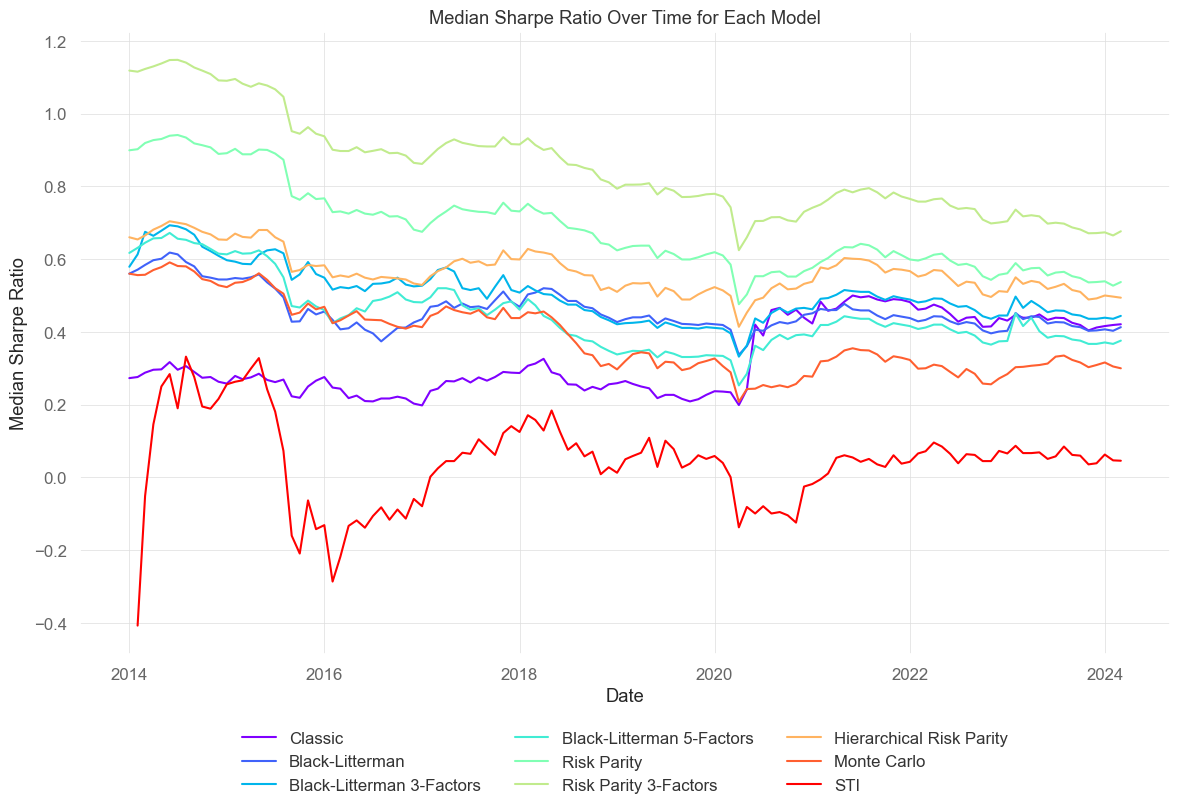

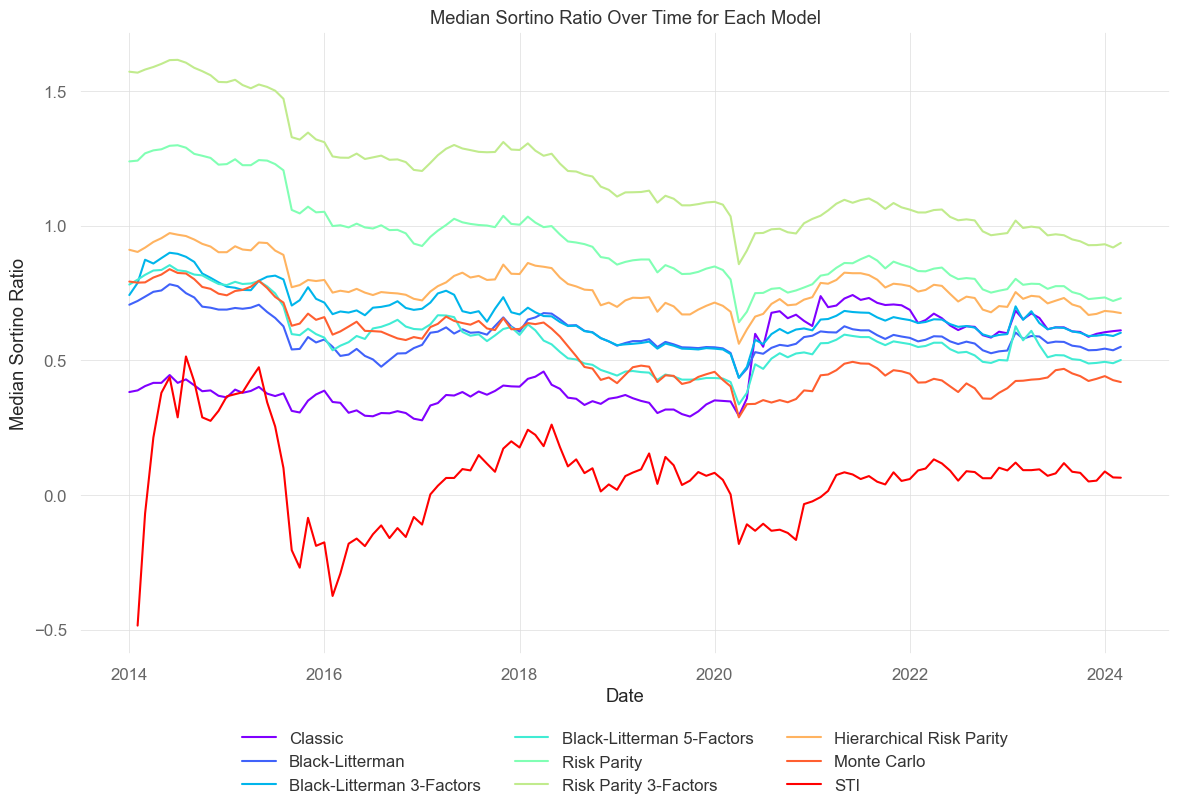

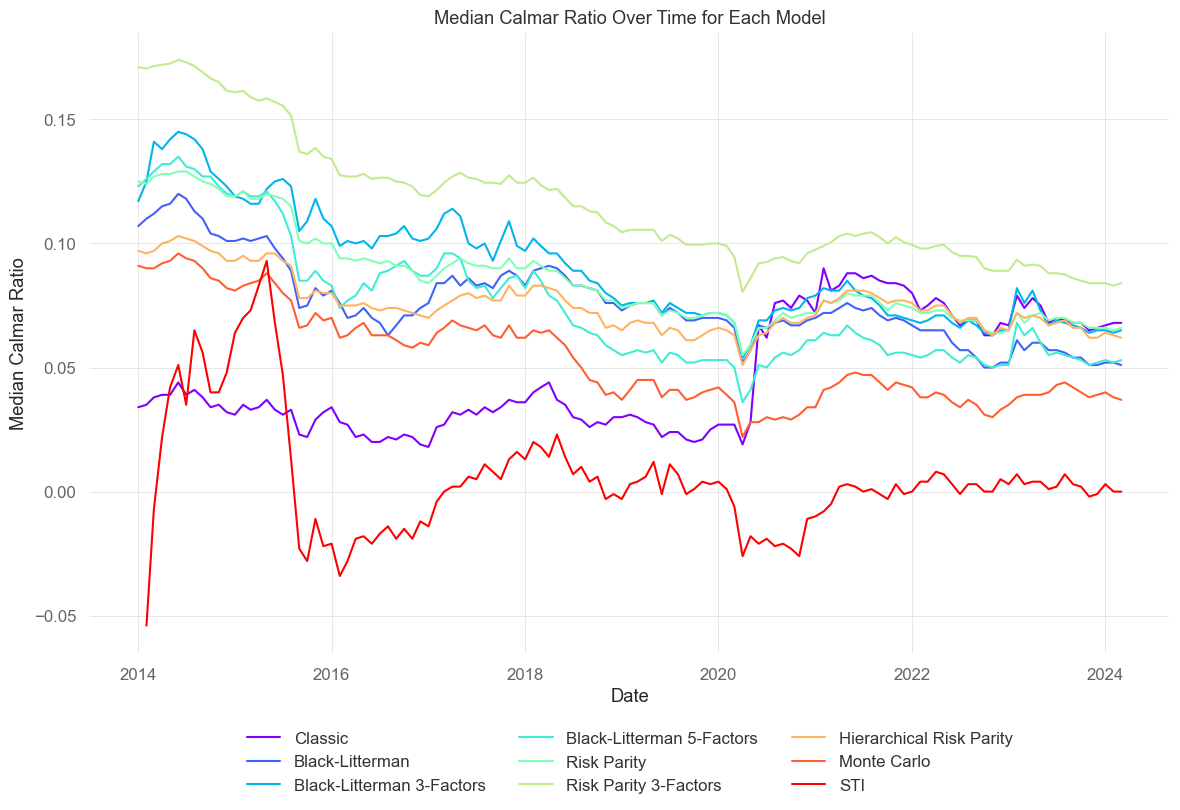

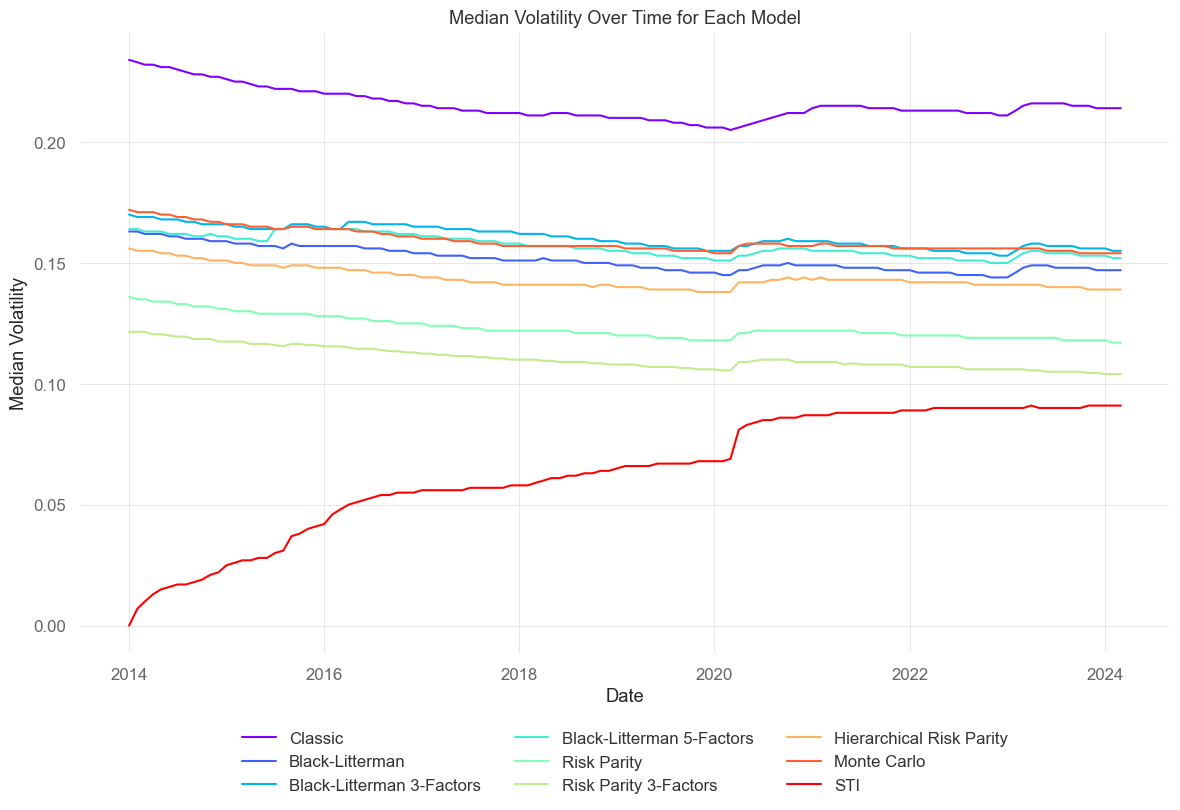

In [27]:
plot_median_values(
    monthly_cumulative_metrics, "Model", monthly_cumulative_metrics["Model"].unique()
)

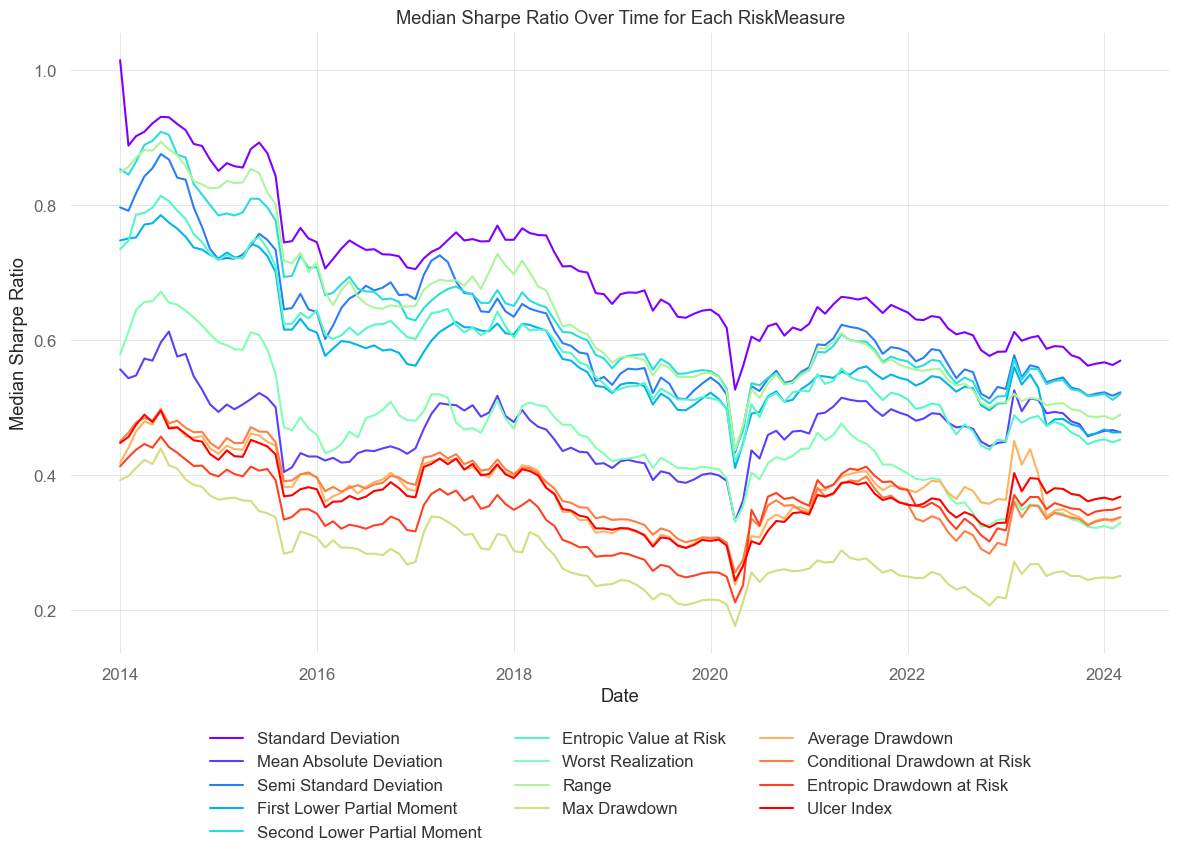

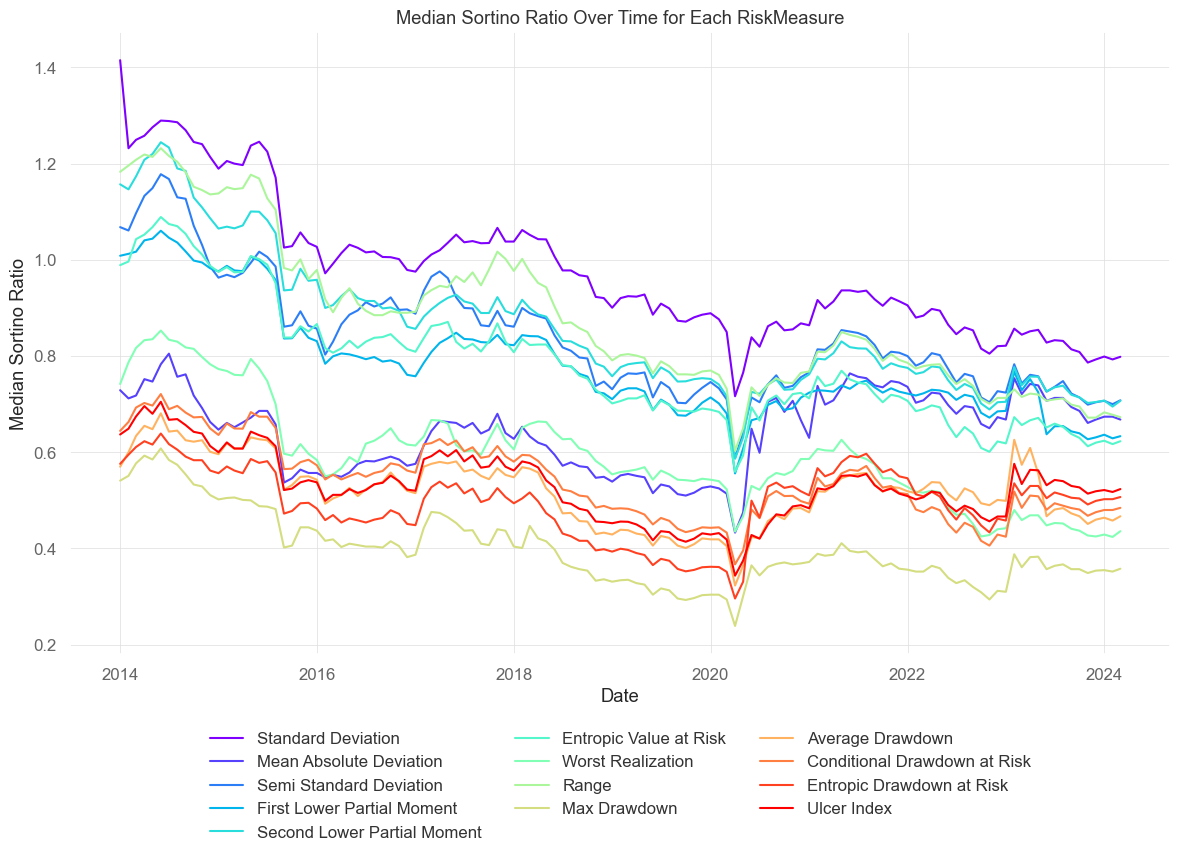

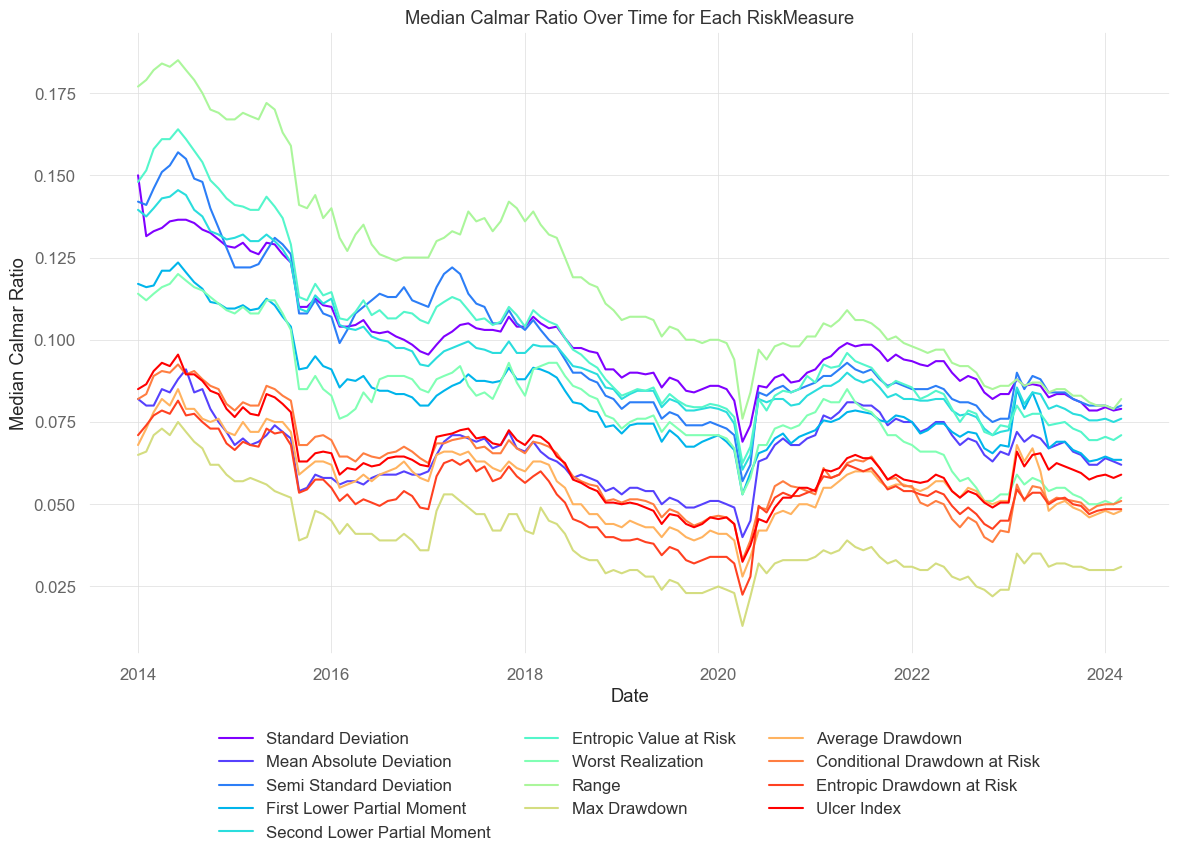

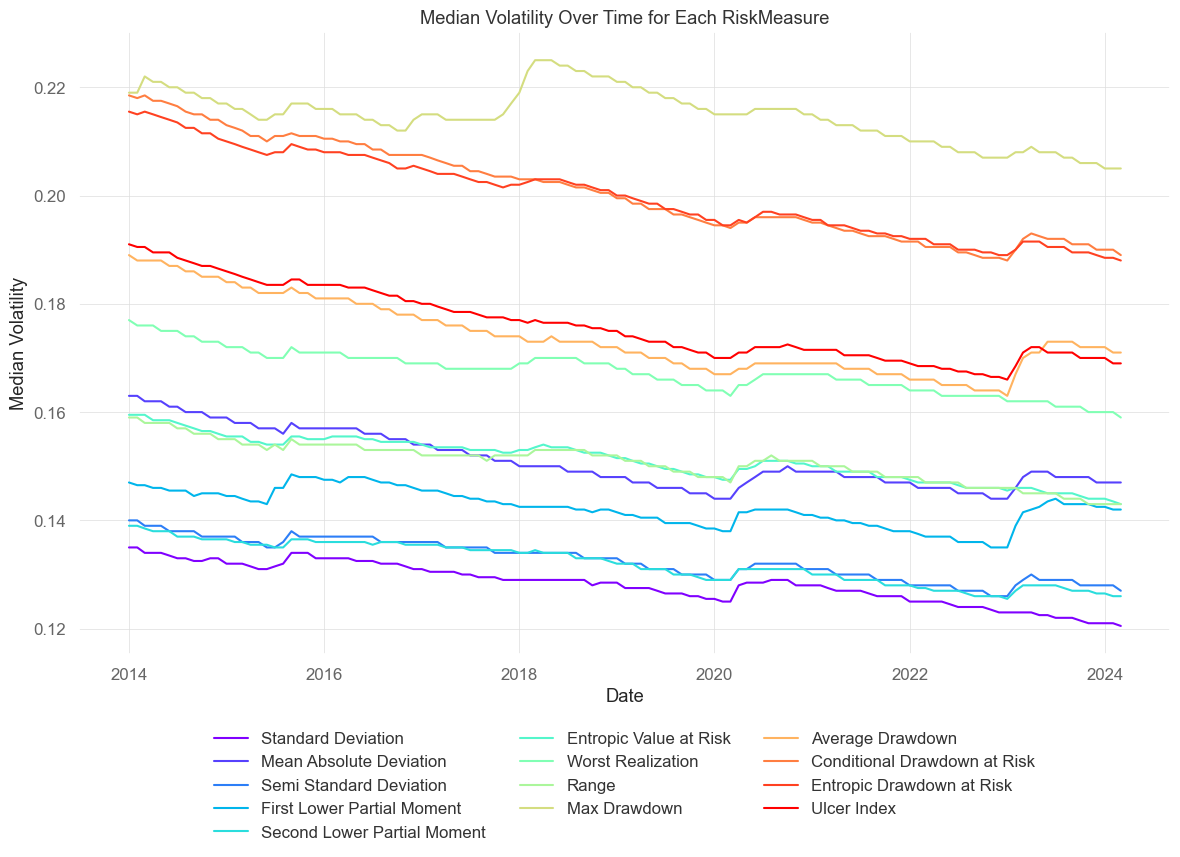

In [28]:
plot_median_values(
    monthly_cumulative_metrics,
    "RiskMeasure",
    monthly_cumulative_metrics["RiskMeasure"].unique(),
)

In [29]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

model_medians_end = (
    monthly_cumulative_metrics.groupby("Model")[metrics].median().round(3)
)

for metric in metrics:
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    ).to_csv(f"../data/backtest/validation/model_{metric}_rankings_Y10.csv")

Rankings and Median Values for Sharpe Ratio:
                           Sharpe Ratio  Sharpe Ratio_Ranking
Model                                                        
Risk Parity 3-Factors             1.006                   1.0
Risk Parity                       0.754                   2.0
Hierarchical Risk Parity          0.603                   3.0
Black-Litterman 3-Factors         0.562                   4.0
Black-Litterman                   0.536                   5.0
Black-Litterman 5-Factors         0.521                   6.0
Monte Carlo                       0.506                   7.0
Classic                           0.373                   8.0
STI                               0.056                   9.0 

Rankings and Median Values for Sortino Ratio:
                           Sortino Ratio  Sortino Ratio_Ranking
Model                                                          
Risk Parity 3-Factors              1.408                    1.0
Risk Parity                      

In [30]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

# Exclude the STI model
monthly_cumulative_metrics_temp = monthly_cumulative_metrics[
    monthly_cumulative_metrics["Model"] != "STI"
]
# Calculate the median values for each model at the end of the period
model_medians_end = (
    monthly_cumulative_metrics_temp.groupby("RiskMeasure")[metrics].median().round(3)
)

# Adjust rankings for each metric and print them separately
for metric in metrics:
    # Rank models based on the current metric, considering the appropriate ascending flag
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    # Print the median values and rankings for the current metric
    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    ).to_csv(f"../data/backtest/validation/rm_{metric}_rankings_Y10.csv")

Rankings and Median Values for Sharpe Ratio:
                              Sharpe Ratio  Sharpe Ratio_Ranking
RiskMeasure                                                     
Standard Deviation                   0.772                   1.0
Semi Standard Deviation              0.734                   2.0
Range                                0.696                   3.0
Second Lower Partial Moment          0.686                   4.0
Entropic Value at Risk               0.631                   5.0
First Lower Partial Moment           0.600                   6.0
Mean Absolute Deviation              0.550                   7.0
Worst Realization                    0.468                   8.0
Conditional Drawdown at Risk         0.453                   9.0
Ulcer Index                          0.443                  10.0
Entropic Drawdown at Risk            0.431                  11.0
Average Drawdown                     0.390                  12.0
Max Drawdown                         0.352   